# Machine Learning Foundation

## Course 6, Part g: Time Series Deep Learning DEMO

# Introduction

- In previous lessons, we've gone from learning the basic components of time series to employing advanced signal transformation techniques. 
- As the culmination of these lessons, we'll now turn toward deep learning as a method for time series forecasting. 
- We'll see how **recurrent neural networks** can automatically learn how to model series components like seasonality and autocorrelation without special preprocessing. 
- In the process, we'll gain exposure to the python library **Keras**, which provides an excellent interface for constructing neural networks. 

## Learning Outcomes
You should walk away from this Python tutorial with:
1. A practical understanding of how to build and train a simple RNN or LSTM for time series forecasting, using keras.
2. Introductory experience in tuning RNN/LSTM parameters.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore')

# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series. We'll use a dataset provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts<sup>1</sup>.

1. Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220â€“10236

#### Setting Up The Data
In this exercise we are going to use [FiveCitiesPM](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) dataset.

We'll start by working with Beijing data, and filter the dataset down to records from 2015. 

In [2]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


- We are interested in attempting to forecast the **'PM'** series, **which are measurements of air pollution for several different districts**.
- Note that there are occasional **missing values** in these series, which we can fill with **simple linear interpolation**.
- To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values. 

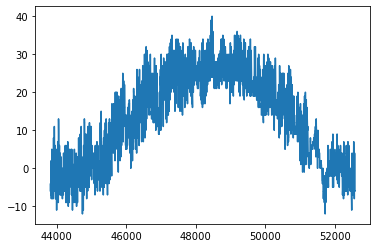

In [3]:
plt.plot(df_Beijing['TEMP'])

In [4]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['TEMP'] = df_Beijing['TEMP'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

In [5]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])
df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
df_Beijing.set_index(df_Beijing.date,inplace=True)

<AxesSubplot:xlabel='date'>

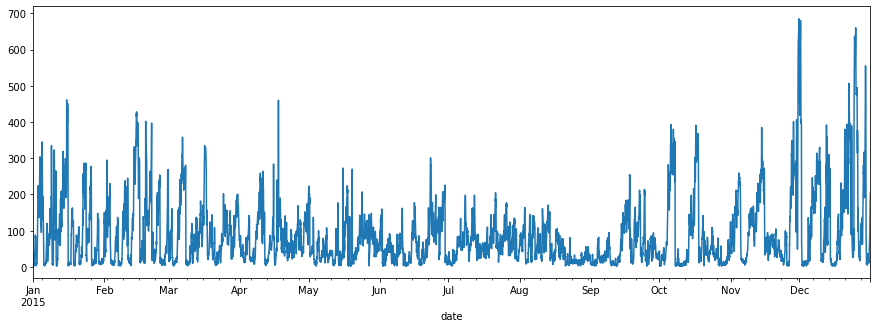

In [6]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df_Beijing['PM_Dongsi'].plot()

In [7]:
df_Beijing['PM_Dongsi']

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

- As usual, it's a good idea for us to generate a run-sequence plot before modeling the data. 
- This way we can get a feel for what we're working with. 
- We'll go ahead and define two utility functions that let us extract and plot the last $n$ days of data (remember that **this is an hourly time series, so each day has 24 time steps**).   

In [8]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

What do the last 6 weeks of data look like?

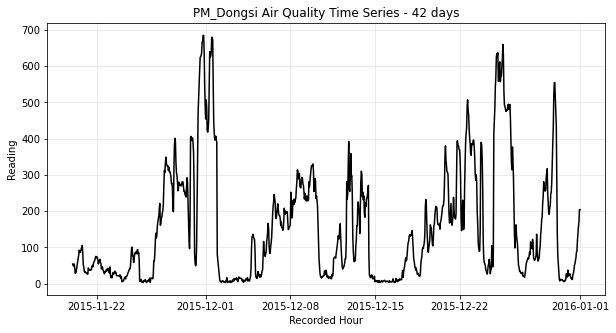

In [9]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

**Review Question**: what components that you've learned in previous lessons appear to be present in this time series? 

**Answer**: There appears to be a periodic component as well as autocorrelation structure.

### Example 1: Train a simple RNN to forecast the PM_Dongsi time series

- Before we can train a neural network with **keras**, we need to **process the data into a format that the library accepts.**
- In particular, for keras RNNs and LSTMs, training samples should be stored in a **3D numpy array of shape** **(n_samples, time_steps, n_features)**. 
- Since we'll be using only the series' history to predict its future, we'll only have **1 feature.** 
- Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.
- To this end, we define utility functions that allow us to extract the formatted data. 
- The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.
- Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [10]:
df_Beijing.shape

(8760, 19)

In [11]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

- With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. 
- We run this function in the cell below. 
- **We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step.**
- We use the last day of data for visually testing the model.    

In [12]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

In [13]:
train_y.shape

(436,)

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [14]:
print(f"Training input shape: {train_X.shape}")
print(f"Training output shape: {train_y.shape}")
print(f"Test input shape: {test_X_init.shape}")
print(f"Test output shape: {test_y.shape}")

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


- And now we're ready to train! 
- Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. 
- Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.  

In [18]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [19]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 43108.8013
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 38006.6240
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 42109.3970
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 44155.8838
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 46575.7119
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 40980.5020
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 45414.0352
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 39596.6450
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 41358.0591
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 41351.7900


- Not bad so far. 
- But we need to work a bit harder to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. 
- **For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model.** 
- **We stop once we've generated all the time step predictions we need.**
- This prediction method and a utility function for plotting its output against the ground truth are defined below. 
- Take some time time to familiarize yourself with the prediction method.    

In [20]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. <br>
We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

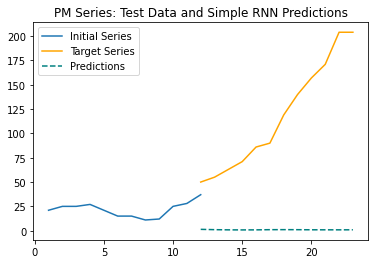

In [21]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is **badly underfit** and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

- We can improve by making the model more expressive, **increasing cell_units**. 
- We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. 
- We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

Epoch 1/1200
7/7 [==============================] - 2s 3ms/step - loss: 47938.0088
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 43077.6436
Epoch 3/1200
7/7 [==============================] - 0s 2ms/step - loss: 45443.7969
Epoch 4/1200
7/7 [==============================] - 0s 2ms/step - loss: 39842.6621
Epoch 5/1200
7/7 [==============================] - 0s 2ms/step - loss: 49689.2178
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 43435.9575
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 39280.5178
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 49922.8447
Epoch 9/1200
7/7 [==============================] - 0s 2ms/step - loss: 40797.1714
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 46706.1074
Epoch 11/1200
7/7 [==============================] - 0s 2ms/step - loss: 40258.0625
Epoch 12/1200
7/7 [==============================] - 0s 2ms/step - loss: 40170.8313
E

7/7 [==============================] - 0s 2ms/step - loss: 29049.5745
Epoch 195/1200
7/7 [==============================] - 0s 2ms/step - loss: 30591.9983
Epoch 196/1200
7/7 [==============================] - 0s 2ms/step - loss: 29905.0039
Epoch 197/1200
7/7 [==============================] - 0s 2ms/step - loss: 30877.4973
Epoch 198/1200
7/7 [==============================] - 0s 2ms/step - loss: 30041.0386
Epoch 199/1200
7/7 [==============================] - 0s 2ms/step - loss: 31030.1023
Epoch 200/1200
7/7 [==============================] - 0s 2ms/step - loss: 27214.6174
Epoch 201/1200
7/7 [==============================] - 0s 2ms/step - loss: 28228.5300
Epoch 202/1200
7/7 [==============================] - 0s 2ms/step - loss: 27964.0818
Epoch 203/1200
7/7 [==============================] - 0s 2ms/step - loss: 34536.6006
Epoch 204/1200
7/7 [==============================] - 0s 2ms/step - loss: 33735.6526
Epoch 205/1200
7/7 [==============================] - 0s 2ms/step - loss: 29865.

7/7 [==============================] - 0s 2ms/step - loss: 23444.3213
Epoch 387/1200
7/7 [==============================] - 0s 2ms/step - loss: 26642.8816
Epoch 388/1200
7/7 [==============================] - 0s 2ms/step - loss: 27466.8872
Epoch 389/1200
7/7 [==============================] - 0s 2ms/step - loss: 27682.0676
Epoch 390/1200
7/7 [==============================] - 0s 2ms/step - loss: 22805.0388
Epoch 391/1200
7/7 [==============================] - 0s 2ms/step - loss: 24571.5562
Epoch 392/1200
7/7 [==============================] - 0s 2ms/step - loss: 22394.0532
Epoch 393/1200
7/7 [==============================] - 0s 2ms/step - loss: 23935.2634
Epoch 394/1200
7/7 [==============================] - 0s 2ms/step - loss: 21371.1267
Epoch 395/1200
7/7 [==============================] - 0s 2ms/step - loss: 24399.4298
Epoch 396/1200
7/7 [==============================] - 0s 2ms/step - loss: 22339.5542
Epoch 397/1200
7/7 [==============================] - 0s 2ms/step - loss: 24768.

7/7 [==============================] - 0s 2ms/step - loss: 21721.9556
Epoch 579/1200
7/7 [==============================] - 0s 2ms/step - loss: 20548.4360
Epoch 580/1200
7/7 [==============================] - 0s 2ms/step - loss: 19477.0525
Epoch 581/1200
7/7 [==============================] - 0s 2ms/step - loss: 18222.3284
Epoch 582/1200
7/7 [==============================] - 0s 2ms/step - loss: 18342.2947
Epoch 583/1200
7/7 [==============================] - 0s 2ms/step - loss: 19095.9285
Epoch 584/1200
7/7 [==============================] - 0s 2ms/step - loss: 18386.2507
Epoch 585/1200
7/7 [==============================] - 0s 2ms/step - loss: 17170.9642
Epoch 586/1200
7/7 [==============================] - 0s 2ms/step - loss: 20019.1172
Epoch 587/1200
7/7 [==============================] - 0s 2ms/step - loss: 16314.4199
Epoch 588/1200
7/7 [==============================] - 0s 2ms/step - loss: 16329.3383
Epoch 589/1200
7/7 [==============================] - 0s 2ms/step - loss: 21117.

7/7 [==============================] - 0s 2ms/step - loss: 17482.4738
Epoch 771/1200
7/7 [==============================] - 0s 2ms/step - loss: 17658.0420
Epoch 772/1200
7/7 [==============================] - 0s 2ms/step - loss: 13388.2656
Epoch 773/1200
7/7 [==============================] - 0s 2ms/step - loss: 16597.3950
Epoch 774/1200
7/7 [==============================] - 0s 2ms/step - loss: 15266.1628
Epoch 775/1200
7/7 [==============================] - 0s 2ms/step - loss: 14497.3032
Epoch 776/1200
7/7 [==============================] - 0s 2ms/step - loss: 15987.1207
Epoch 777/1200
7/7 [==============================] - 0s 2ms/step - loss: 14957.6008
Epoch 778/1200
7/7 [==============================] - 0s 2ms/step - loss: 15342.9089
Epoch 779/1200
7/7 [==============================] - 0s 2ms/step - loss: 15175.3198
Epoch 780/1200
7/7 [==============================] - 0s 2ms/step - loss: 15076.6951
Epoch 781/1200
7/7 [==============================] - 0s 2ms/step - loss: 13876.

7/7 [==============================] - 0s 2ms/step - loss: 11267.0266
Epoch 963/1200
7/7 [==============================] - 0s 2ms/step - loss: 10401.7607
Epoch 964/1200
7/7 [==============================] - 0s 2ms/step - loss: 11604.4003
Epoch 965/1200
7/7 [==============================] - 0s 2ms/step - loss: 11082.8737
Epoch 966/1200
7/7 [==============================] - 0s 2ms/step - loss: 12324.0287
Epoch 967/1200
7/7 [==============================] - 0s 2ms/step - loss: 11966.3484
Epoch 968/1200
7/7 [==============================] - 0s 2ms/step - loss: 12029.1016
Epoch 969/1200
7/7 [==============================] - 0s 2ms/step - loss: 12804.3314
Epoch 970/1200
7/7 [==============================] - 0s 2ms/step - loss: 13234.7662
Epoch 971/1200
7/7 [==============================] - 0s 2ms/step - loss: 11531.7000
Epoch 972/1200
7/7 [==============================] - 0s 2ms/step - loss: 9566.8149
Epoch 973/1200
7/7 [==============================] - 0s 2ms/step - loss: 10445.9

7/7 [==============================] - 0s 2ms/step - loss: 10574.6163
Epoch 1059/1200
7/7 [==============================] - 0s 2ms/step - loss: 8686.8842
Epoch 1060/1200
7/7 [==============================] - 0s 2ms/step - loss: 9716.8580
Epoch 1061/1200
7/7 [==============================] - 0s 2ms/step - loss: 10113.9615
Epoch 1062/1200
7/7 [==============================] - 0s 2ms/step - loss: 10932.1161
Epoch 1063/1200
7/7 [==============================] - 0s 2ms/step - loss: 8013.3785
Epoch 1064/1200
7/7 [==============================] - 0s 2ms/step - loss: 10442.2981
Epoch 1065/1200
7/7 [==============================] - 0s 2ms/step - loss: 9130.9023
Epoch 1066/1200
7/7 [==============================] - 0s 2ms/step - loss: 8558.0587
Epoch 1067/1200
7/7 [==============================] - 0s 2ms/step - loss: 10145.9488
Epoch 1068/1200
7/7 [==============================] - 0s 2ms/step - loss: 9403.7393
Epoch 1069/1200
7/7 [==============================] - 0s 2ms/step - loss: 9

7/7 [==============================] - 0s 2ms/step - loss: 7541.2468
Epoch 1155/1200
7/7 [==============================] - 0s 2ms/step - loss: 9043.8668
Epoch 1156/1200
7/7 [==============================] - 0s 2ms/step - loss: 9008.3937
Epoch 1157/1200
7/7 [==============================] - 0s 2ms/step - loss: 8893.8613
Epoch 1158/1200
7/7 [==============================] - 0s 2ms/step - loss: 9758.9994
Epoch 1159/1200
7/7 [==============================] - 0s 2ms/step - loss: 10311.4171
Epoch 1160/1200
7/7 [==============================] - 0s 2ms/step - loss: 8414.1560
Epoch 1161/1200
7/7 [==============================] - 0s 2ms/step - loss: 8010.9285
Epoch 1162/1200
7/7 [==============================] - 0s 2ms/step - loss: 9385.3864
Epoch 1163/1200
7/7 [==============================] - 0s 2ms/step - loss: 8127.6094
Epoch 1164/1200
7/7 [==============================] - 0s 2ms/step - loss: 8645.2059
Epoch 1165/1200
7/7 [==============================] - 0s 2ms/step - loss: 8297.

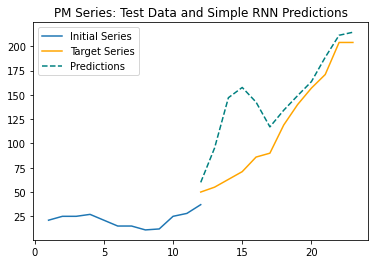

In [22]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

- We can definitely get better results than before. 
- Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence).
- Once we've created a model object, we can also get information about its structure and number of parameters by using the **summary** function.
- This is a useful way to measure the complexity of the model and get a feel for how long it may take to train. 

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


- Note that even for this relatively simple model, we already have almost a thousand parameters to train. 
- A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming.    

### Exercise 1: Train a simple RNN to forecast the PM_Nongzhanguan time series

- We can reuse all of the functions we've defined so far in order to train models on different time series. 
- In this exercise, you'll train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.

**Step 1**: Interpolate the missing values in the "PM_Nongzhanguan" series and plot the last 42 days of the series to get a feel for the data.

In [24]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

date
2015-01-01 00:00:00     8.0
2015-01-01 01:00:00     7.0
2015-01-01 02:00:00     7.0
2015-01-01 03:00:00    11.0
2015-01-01 04:00:00     5.0
2015-01-01 05:00:00     3.0
2015-01-01 06:00:00     6.0
2015-01-01 07:00:00     7.0
2015-01-01 08:00:00     9.0
2015-01-01 09:00:00    11.0
Name: PM_Nongzhanguan, dtype: float64

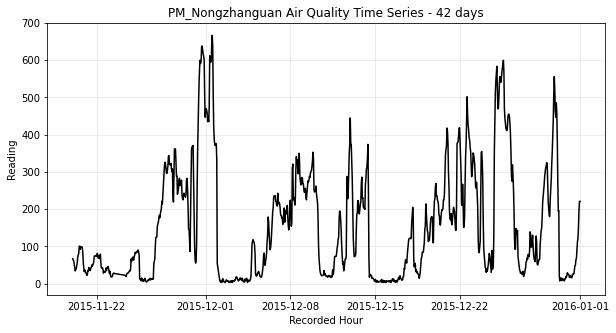

In [25]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

**Step 2**: Extract the train and test data for the "PM_Nongzhanguan" series using the function **get_train_test_data**. Use the following set of parameters:  

* **series_days** : 56
* **input_hours** : 6
* **test_hours** : 12

For reference, below is how we called the function earlier on. You can also pull up the function's documentation to review the various arguments. 

```
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))
```

In [26]:
series_days = 56
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

**Step 3**: Using the extracted train data to fit a simple RNN, and use the test data to generate and plot predictions.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

For reference, here's example code that you can adapt:
```
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
```

Epoch 1/1200
7/7 [==============================] - 1s 2ms/step - loss: 37397.5007
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 43566.9199
Epoch 3/1200
7/7 [==============================] - 0s 2ms/step - loss: 38218.5771
Epoch 4/1200
7/7 [==============================] - 0s 2ms/step - loss: 35357.7305
Epoch 5/1200
7/7 [==============================] - 0s 2ms/step - loss: 34279.3313
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 40471.1216
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 38010.4326
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 40138.6836
Epoch 9/1200
7/7 [==============================] - 0s 2ms/step - loss: 39386.2114
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 36438.6477
Epoch 11/1200
7/7 [==============================] - 0s 2ms/step - loss: 40365.9580
Epoch 12/1200
7/7 [==============================] - 0s 2ms/step - loss: 36630.2612
E

7/7 [==============================] - 0s 2ms/step - loss: 24595.8958
Epoch 195/1200
7/7 [==============================] - 0s 2ms/step - loss: 28042.5740
Epoch 196/1200
7/7 [==============================] - 0s 1ms/step - loss: 28177.0315
Epoch 197/1200
7/7 [==============================] - 0s 1ms/step - loss: 26476.2200
Epoch 198/1200
7/7 [==============================] - 0s 1ms/step - loss: 24424.3184
Epoch 199/1200
7/7 [==============================] - 0s 1ms/step - loss: 24261.7285
Epoch 200/1200
7/7 [==============================] - 0s 1ms/step - loss: 24618.0735
Epoch 201/1200
7/7 [==============================] - 0s 1ms/step - loss: 24998.7332
Epoch 202/1200
7/7 [==============================] - 0s 1ms/step - loss: 26023.4709
Epoch 203/1200
7/7 [==============================] - 0s 2ms/step - loss: 27392.1636
Epoch 204/1200
7/7 [==============================] - 0s 1ms/step - loss: 24478.9211
Epoch 205/1200
7/7 [==============================] - 0s 1ms/step - loss: 21362.

7/7 [==============================] - 0s 2ms/step - loss: 17422.6553
Epoch 387/1200
7/7 [==============================] - 0s 1ms/step - loss: 15196.2023
Epoch 388/1200
7/7 [==============================] - 0s 1ms/step - loss: 14840.5444
Epoch 389/1200
7/7 [==============================] - 0s 1ms/step - loss: 16724.3446
Epoch 390/1200
7/7 [==============================] - 0s 1ms/step - loss: 16022.9197
Epoch 391/1200
7/7 [==============================] - 0s 1ms/step - loss: 17182.6752
Epoch 392/1200
7/7 [==============================] - 0s 1ms/step - loss: 14542.6803
Epoch 393/1200
7/7 [==============================] - 0s 1ms/step - loss: 16056.8717
Epoch 394/1200
7/7 [==============================] - 0s 1ms/step - loss: 15101.9415
Epoch 395/1200
7/7 [==============================] - 0s 2ms/step - loss: 13672.4178
Epoch 396/1200
7/7 [==============================] - 0s 2ms/step - loss: 17510.9736
Epoch 397/1200
7/7 [==============================] - 0s 1ms/step - loss: 15027.

7/7 [==============================] - 0s 1ms/step - loss: 11572.6547
Epoch 579/1200
7/7 [==============================] - 0s 1ms/step - loss: 9894.3271
Epoch 580/1200
7/7 [==============================] - 0s 2ms/step - loss: 10604.1233
Epoch 581/1200
7/7 [==============================] - 0s 1ms/step - loss: 9387.3658
Epoch 582/1200
7/7 [==============================] - 0s 1ms/step - loss: 11096.6089
Epoch 583/1200
7/7 [==============================] - 0s 1ms/step - loss: 9625.8948
Epoch 584/1200
7/7 [==============================] - 0s 1ms/step - loss: 10188.8506
Epoch 585/1200
7/7 [==============================] - 0s 1ms/step - loss: 11945.7415
Epoch 586/1200
7/7 [==============================] - 0s 2ms/step - loss: 9969.8152
Epoch 587/1200
7/7 [==============================] - 0s 2ms/step - loss: 9744.1149
Epoch 588/1200
7/7 [==============================] - 0s 2ms/step - loss: 10023.8386
Epoch 589/1200
7/7 [==============================] - 0s 1ms/step - loss: 8889.1180
E

7/7 [==============================] - 0s 1ms/step - loss: 7379.4221
Epoch 773/1200
7/7 [==============================] - 0s 1ms/step - loss: 6712.0793
Epoch 774/1200
7/7 [==============================] - 0s 2ms/step - loss: 7195.2820
Epoch 775/1200
7/7 [==============================] - 0s 1ms/step - loss: 6652.9453
Epoch 776/1200
7/7 [==============================] - 0s 1ms/step - loss: 6860.7054
Epoch 777/1200
7/7 [==============================] - 0s 2ms/step - loss: 6480.9579
Epoch 778/1200
7/7 [==============================] - 0s 1ms/step - loss: 7279.6080
Epoch 779/1200
7/7 [==============================] - 0s 1ms/step - loss: 6998.1750
Epoch 780/1200
7/7 [==============================] - 0s 1ms/step - loss: 6572.3083
Epoch 781/1200
7/7 [==============================] - 0s 1ms/step - loss: 6572.6275
Epoch 782/1200
7/7 [==============================] - 0s 1ms/step - loss: 6974.8795
Epoch 783/1200
7/7 [==============================] - 0s 1ms/step - loss: 7702.1898
Epoch 7

7/7 [==============================] - 0s 2ms/step - loss: 4162.9357
Epoch 967/1200
7/7 [==============================] - 0s 2ms/step - loss: 4564.5748
Epoch 968/1200
7/7 [==============================] - 0s 2ms/step - loss: 4580.8398
Epoch 969/1200
7/7 [==============================] - 0s 2ms/step - loss: 5941.8932
Epoch 970/1200
7/7 [==============================] - 0s 2ms/step - loss: 4529.7455
Epoch 971/1200
7/7 [==============================] - 0s 2ms/step - loss: 5147.3867
Epoch 972/1200
7/7 [==============================] - 0s 2ms/step - loss: 4225.0515
Epoch 973/1200
7/7 [==============================] - 0s 2ms/step - loss: 4778.1652
Epoch 974/1200
7/7 [==============================] - 0s 2ms/step - loss: 5413.7560
Epoch 975/1200
7/7 [==============================] - 0s 2ms/step - loss: 5001.7047
Epoch 976/1200
7/7 [==============================] - 0s 2ms/step - loss: 5187.3111
Epoch 977/1200
7/7 [==============================] - 0s 2ms/step - loss: 4514.6327
Epoch 9

Epoch 1063/1200
7/7 [==============================] - 0s 2ms/step - loss: 3957.2628
Epoch 1064/1200
7/7 [==============================] - 0s 2ms/step - loss: 3744.1470
Epoch 1065/1200
7/7 [==============================] - 0s 1ms/step - loss: 3536.0551
Epoch 1066/1200
7/7 [==============================] - 0s 1ms/step - loss: 3345.6066
Epoch 1067/1200
7/7 [==============================] - 0s 1ms/step - loss: 3915.0250
Epoch 1068/1200
7/7 [==============================] - 0s 1ms/step - loss: 2697.0169
Epoch 1069/1200
7/7 [==============================] - 0s 2ms/step - loss: 3340.6352
Epoch 1070/1200
7/7 [==============================] - 0s 1ms/step - loss: 3987.1193
Epoch 1071/1200
7/7 [==============================] - 0s 2ms/step - loss: 4383.8506
Epoch 1072/1200
7/7 [==============================] - 0s 1ms/step - loss: 4602.2945
Epoch 1073/1200
7/7 [==============================] - 0s 1ms/step - loss: 4278.9567
Epoch 1074/1200
7/7 [==============================] - 0s 2ms/ste

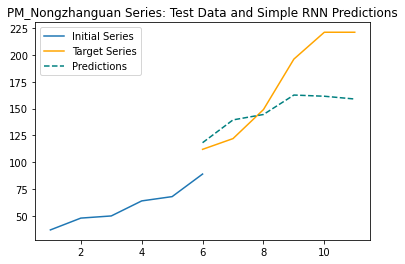

In [29]:
model = fit_SimpleRNN(train_X, train_y, cell_units=50, epochs=1200)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and Simple RNN Predictions')

Again, we're able to do a decent job forecasting the continuation of an uptrend. We'll likely face more difficulty if we try to predict further into the future, especially with a simple RNN. 

# Section 2: LSTM

- In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. 
- Our first step will be to write a new function for fitting an LSTM with keras notice that it's almost the same as our simple RNN function, with **LSTM** substitued for **SimpleRNN** (this is a nice display of how flexible keras is). 

Take some time to review the logic of the function while we go ahead and run the example cell below (it will take a while). 

In [30]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

### Example 2: Train a LSTM to forecast the PM_Nongzhanguan time series

- With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. 
- We can extract the data as we did before, call the **fit_LSTM** function to build a model, and run the same *predict_and_plot* code.
- Remember that one of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies.
- To see this evidence of this, we'll set *input_hours* to 12 and *test_hours* to 96 and see how our model predictions turn out with LSTM.  

Epoch 1/3000
6/6 [==============================] - 4s 7ms/step - loss: 44171.0910
Epoch 2/3000
6/6 [==============================] - 0s 6ms/step - loss: 48820.9085
Epoch 3/3000
6/6 [==============================] - 0s 6ms/step - loss: 49507.4252
Epoch 4/3000
6/6 [==============================] - 0s 6ms/step - loss: 44665.8655
Epoch 5/3000
6/6 [==============================] - 0s 6ms/step - loss: 40528.6373
Epoch 6/3000
6/6 [==============================] - 0s 6ms/step - loss: 44630.8549
Epoch 7/3000
6/6 [==============================] - 0s 6ms/step - loss: 43730.1875
Epoch 8/3000
6/6 [==============================] - 0s 6ms/step - loss: 43007.7751
Epoch 9/3000
6/6 [==============================] - 0s 6ms/step - loss: 42379.9944
Epoch 10/3000
6/6 [==============================] - 0s 6ms/step - loss: 46404.0246
Epoch 11/3000
6/6 [==============================] - 0s 6ms/step - loss: 38755.1479
Epoch 12/3000
6/6 [==============================] - 0s 6ms/step - loss: 42401.5508
E

6/6 [==============================] - 0s 6ms/step - loss: 24217.4618
Epoch 195/3000
6/6 [==============================] - 0s 6ms/step - loss: 24561.5466
Epoch 196/3000
6/6 [==============================] - 0s 6ms/step - loss: 24730.4506
Epoch 197/3000
6/6 [==============================] - 0s 6ms/step - loss: 30504.1842
Epoch 198/3000
6/6 [==============================] - 0s 6ms/step - loss: 25869.0335
Epoch 199/3000
6/6 [==============================] - 0s 6ms/step - loss: 24913.7804
Epoch 200/3000
6/6 [==============================] - 0s 6ms/step - loss: 26968.7095
Epoch 201/3000
6/6 [==============================] - 0s 6ms/step - loss: 26439.5552
Epoch 202/3000
6/6 [==============================] - 0s 6ms/step - loss: 26151.5711
Epoch 203/3000
6/6 [==============================] - 0s 6ms/step - loss: 22686.9713
Epoch 204/3000
6/6 [==============================] - 0s 6ms/step - loss: 22601.4682
Epoch 205/3000
6/6 [==============================] - 0s 6ms/step - loss: 23497.

6/6 [==============================] - 0s 6ms/step - loss: 16824.6996
Epoch 387/3000
6/6 [==============================] - 0s 6ms/step - loss: 15095.3765
Epoch 388/3000
6/6 [==============================] - 0s 6ms/step - loss: 16450.1611
Epoch 389/3000
6/6 [==============================] - 0s 6ms/step - loss: 16907.4833
Epoch 390/3000
6/6 [==============================] - 0s 6ms/step - loss: 14960.1105
Epoch 391/3000
6/6 [==============================] - 0s 6ms/step - loss: 16043.4230
Epoch 392/3000
6/6 [==============================] - 0s 6ms/step - loss: 15794.7476
Epoch 393/3000
6/6 [==============================] - 0s 6ms/step - loss: 18117.9289
Epoch 394/3000
6/6 [==============================] - 0s 6ms/step - loss: 16619.4925
Epoch 395/3000
6/6 [==============================] - 0s 6ms/step - loss: 15080.9456
Epoch 396/3000
6/6 [==============================] - 0s 6ms/step - loss: 12750.3670
Epoch 397/3000
6/6 [==============================] - 0s 6ms/step - loss: 14532.

6/6 [==============================] - 0s 6ms/step - loss: 8861.8596
Epoch 579/3000
6/6 [==============================] - 0s 6ms/step - loss: 9310.5392
Epoch 580/3000
6/6 [==============================] - 0s 6ms/step - loss: 10710.0347
Epoch 581/3000
6/6 [==============================] - 0s 6ms/step - loss: 8657.7287
Epoch 582/3000
6/6 [==============================] - 0s 6ms/step - loss: 10975.6183
Epoch 583/3000
6/6 [==============================] - 0s 6ms/step - loss: 10083.0799
Epoch 584/3000
6/6 [==============================] - 0s 6ms/step - loss: 12558.6620
Epoch 585/3000
6/6 [==============================] - 0s 6ms/step - loss: 8746.2675
Epoch 586/3000
6/6 [==============================] - 0s 6ms/step - loss: 8582.0603
Epoch 587/3000
6/6 [==============================] - 0s 6ms/step - loss: 10684.4269
Epoch 588/3000
6/6 [==============================] - 0s 6ms/step - loss: 9405.5795
Epoch 589/3000
6/6 [==============================] - 0s 6ms/step - loss: 9615.3438
Ep

6/6 [==============================] - 0s 6ms/step - loss: 7497.6505
Epoch 773/3000
6/6 [==============================] - 0s 6ms/step - loss: 8051.7328
Epoch 774/3000
6/6 [==============================] - 0s 6ms/step - loss: 6665.0785
Epoch 775/3000
6/6 [==============================] - 0s 6ms/step - loss: 6710.5414
Epoch 776/3000
6/6 [==============================] - 0s 6ms/step - loss: 7186.0799
Epoch 777/3000
6/6 [==============================] - 0s 6ms/step - loss: 6774.7344
Epoch 778/3000
6/6 [==============================] - 0s 6ms/step - loss: 6299.4582
Epoch 779/3000
6/6 [==============================] - 0s 6ms/step - loss: 6674.5947
Epoch 780/3000
6/6 [==============================] - 0s 6ms/step - loss: 5319.1056
Epoch 781/3000
6/6 [==============================] - 0s 6ms/step - loss: 7500.3019
Epoch 782/3000
6/6 [==============================] - 0s 6ms/step - loss: 6692.9460
Epoch 783/3000
6/6 [==============================] - 0s 6ms/step - loss: 7672.7724
Epoch 7

6/6 [==============================] - 0s 6ms/step - loss: 5340.8914
Epoch 967/3000
6/6 [==============================] - 0s 6ms/step - loss: 4616.8853
Epoch 968/3000
6/6 [==============================] - 0s 6ms/step - loss: 4187.2686
Epoch 969/3000
6/6 [==============================] - 0s 6ms/step - loss: 5163.4338
Epoch 970/3000
6/6 [==============================] - 0s 6ms/step - loss: 5417.7416
Epoch 971/3000
6/6 [==============================] - 0s 6ms/step - loss: 4894.8781
Epoch 972/3000
6/6 [==============================] - 0s 6ms/step - loss: 3743.6798
Epoch 973/3000
6/6 [==============================] - 0s 7ms/step - loss: 4082.6095
Epoch 974/3000
6/6 [==============================] - 0s 6ms/step - loss: 4319.7906
Epoch 975/3000
6/6 [==============================] - 0s 6ms/step - loss: 4961.4644
Epoch 976/3000
6/6 [==============================] - 0s 6ms/step - loss: 3775.6551
Epoch 977/3000
6/6 [==============================] - 0s 6ms/step - loss: 4103.0090
Epoch 9

Epoch 1063/3000
6/6 [==============================] - 0s 6ms/step - loss: 3688.7426
Epoch 1064/3000
6/6 [==============================] - 0s 6ms/step - loss: 3773.7285
Epoch 1065/3000
6/6 [==============================] - 0s 6ms/step - loss: 4412.1580
Epoch 1066/3000
6/6 [==============================] - 0s 6ms/step - loss: 3984.5733
Epoch 1067/3000
6/6 [==============================] - 0s 7ms/step - loss: 3738.6019
Epoch 1068/3000
6/6 [==============================] - 0s 6ms/step - loss: 3490.6426
Epoch 1069/3000
6/6 [==============================] - 0s 6ms/step - loss: 3611.4337
Epoch 1070/3000
6/6 [==============================] - 0s 6ms/step - loss: 4110.8810
Epoch 1071/3000
6/6 [==============================] - 0s 6ms/step - loss: 3993.7788
Epoch 1072/3000
6/6 [==============================] - 0s 6ms/step - loss: 3062.3278
Epoch 1073/3000
6/6 [==============================] - 0s 7ms/step - loss: 3529.9205
Epoch 1074/3000
6/6 [==============================] - 0s 6ms/ste

6/6 [==============================] - 0s 6ms/step - loss: 2733.4743
Epoch 1256/3000
6/6 [==============================] - 0s 6ms/step - loss: 2685.3170
Epoch 1257/3000
6/6 [==============================] - 0s 6ms/step - loss: 2798.8981
Epoch 1258/3000
6/6 [==============================] - 0s 6ms/step - loss: 2343.1766
Epoch 1259/3000
6/6 [==============================] - 0s 6ms/step - loss: 2320.4782
Epoch 1260/3000
6/6 [==============================] - 0s 6ms/step - loss: 2958.3250
Epoch 1261/3000
6/6 [==============================] - 0s 6ms/step - loss: 2811.8105
Epoch 1262/3000
6/6 [==============================] - 0s 6ms/step - loss: 2000.0552
Epoch 1263/3000
6/6 [==============================] - 0s 6ms/step - loss: 2338.1060
Epoch 1264/3000
6/6 [==============================] - 0s 6ms/step - loss: 2504.8505
Epoch 1265/3000
6/6 [==============================] - 0s 6ms/step - loss: 2614.5511
Epoch 1266/3000
6/6 [==============================] - 0s 6ms/step - loss: 3572.0

6/6 [==============================] - 0s 6ms/step - loss: 1574.5389
Epoch 1448/3000
6/6 [==============================] - 0s 6ms/step - loss: 1774.1827
Epoch 1449/3000
6/6 [==============================] - 0s 6ms/step - loss: 2000.3850
Epoch 1450/3000
6/6 [==============================] - 0s 6ms/step - loss: 1818.7926
Epoch 1451/3000
6/6 [==============================] - 0s 7ms/step - loss: 1542.2820
Epoch 1452/3000
6/6 [==============================] - 0s 6ms/step - loss: 2053.7213
Epoch 1453/3000
6/6 [==============================] - 0s 6ms/step - loss: 1640.1954
Epoch 1454/3000
6/6 [==============================] - 0s 6ms/step - loss: 1696.0289
Epoch 1455/3000
6/6 [==============================] - 0s 6ms/step - loss: 2357.1467
Epoch 1456/3000
6/6 [==============================] - 0s 6ms/step - loss: 1199.4066
Epoch 1457/3000
6/6 [==============================] - 0s 7ms/step - loss: 1887.1612
Epoch 1458/3000
6/6 [==============================] - 0s 6ms/step - loss: 1352.8

6/6 [==============================] - 0s 6ms/step - loss: 1289.9226
Epoch 1640/3000
6/6 [==============================] - 0s 6ms/step - loss: 1209.0830
Epoch 1641/3000
6/6 [==============================] - 0s 6ms/step - loss: 814.2613
Epoch 1642/3000
6/6 [==============================] - 0s 6ms/step - loss: 1233.4019
Epoch 1643/3000
6/6 [==============================] - 0s 6ms/step - loss: 1142.1276
Epoch 1644/3000
6/6 [==============================] - 0s 6ms/step - loss: 1468.5563
Epoch 1645/3000
6/6 [==============================] - 0s 6ms/step - loss: 871.0793
Epoch 1646/3000
6/6 [==============================] - 0s 6ms/step - loss: 1049.1323
Epoch 1647/3000
6/6 [==============================] - 0s 6ms/step - loss: 1148.1881
Epoch 1648/3000
6/6 [==============================] - 0s 6ms/step - loss: 1193.9063
Epoch 1649/3000
6/6 [==============================] - 0s 6ms/step - loss: 867.5618
Epoch 1650/3000
6/6 [==============================] - 0s 6ms/step - loss: 1310.6144

6/6 [==============================] - 0s 7ms/step - loss: 753.5986
Epoch 1737/3000
6/6 [==============================] - 0s 6ms/step - loss: 770.0286
Epoch 1738/3000
6/6 [==============================] - 0s 6ms/step - loss: 910.4787
Epoch 1739/3000
6/6 [==============================] - 0s 6ms/step - loss: 1011.9363
Epoch 1740/3000
6/6 [==============================] - 0s 6ms/step - loss: 942.8424
Epoch 1741/3000
6/6 [==============================] - 0s 6ms/step - loss: 849.9747
Epoch 1742/3000
6/6 [==============================] - 0s 6ms/step - loss: 907.0026
Epoch 1743/3000
6/6 [==============================] - 0s 6ms/step - loss: 1117.3985
Epoch 1744/3000
6/6 [==============================] - 0s 6ms/step - loss: 807.0375
Epoch 1745/3000
6/6 [==============================] - 0s 6ms/step - loss: 914.9263
Epoch 1746/3000
6/6 [==============================] - 0s 6ms/step - loss: 1163.2534
Epoch 1747/3000
6/6 [==============================] - 0s 6ms/step - loss: 819.7633
Epoch

6/6 [==============================] - 0s 6ms/step - loss: 496.4568
Epoch 1931/3000
6/6 [==============================] - 0s 6ms/step - loss: 597.9703
Epoch 1932/3000
6/6 [==============================] - 0s 6ms/step - loss: 527.7951
Epoch 1933/3000
6/6 [==============================] - 0s 8ms/step - loss: 534.9751
Epoch 1934/3000
6/6 [==============================] - 0s 7ms/step - loss: 645.0953
Epoch 1935/3000
6/6 [==============================] - 0s 7ms/step - loss: 645.2349
Epoch 1936/3000
6/6 [==============================] - 0s 6ms/step - loss: 482.4002
Epoch 1937/3000
6/6 [==============================] - 0s 7ms/step - loss: 497.8095
Epoch 1938/3000
6/6 [==============================] - 0s 7ms/step - loss: 404.3358
Epoch 1939/3000
6/6 [==============================] - 0s 6ms/step - loss: 445.9819
Epoch 1940/3000
6/6 [==============================] - 0s 6ms/step - loss: 633.9600
Epoch 1941/3000
6/6 [==============================] - 0s 6ms/step - loss: 587.5277
Epoch 19

6/6 [==============================] - 0s 6ms/step - loss: 424.4131
Epoch 2125/3000
6/6 [==============================] - 0s 6ms/step - loss: 581.8313
Epoch 2126/3000
6/6 [==============================] - 0s 6ms/step - loss: 466.1777
Epoch 2127/3000
6/6 [==============================] - 0s 6ms/step - loss: 457.1480
Epoch 2128/3000
6/6 [==============================] - 0s 6ms/step - loss: 389.2831
Epoch 2129/3000
6/6 [==============================] - 0s 6ms/step - loss: 485.4926
Epoch 2130/3000
6/6 [==============================] - 0s 7ms/step - loss: 472.7222
Epoch 2131/3000
6/6 [==============================] - 0s 6ms/step - loss: 428.0144
Epoch 2132/3000
6/6 [==============================] - 0s 6ms/step - loss: 386.8183
Epoch 2133/3000
6/6 [==============================] - 0s 6ms/step - loss: 302.5273
Epoch 2134/3000
6/6 [==============================] - 0s 6ms/step - loss: 442.9189
Epoch 2135/3000
6/6 [==============================] - 0s 6ms/step - loss: 341.9261
Epoch 21

6/6 [==============================] - 0s 6ms/step - loss: 136.6387
Epoch 2319/3000
6/6 [==============================] - 0s 6ms/step - loss: 197.8525
Epoch 2320/3000
6/6 [==============================] - 0s 6ms/step - loss: 199.6066
Epoch 2321/3000
6/6 [==============================] - 0s 6ms/step - loss: 232.2013
Epoch 2322/3000
6/6 [==============================] - 0s 6ms/step - loss: 140.9578
Epoch 2323/3000
6/6 [==============================] - 0s 6ms/step - loss: 165.8845
Epoch 2324/3000
6/6 [==============================] - 0s 6ms/step - loss: 188.8300
Epoch 2325/3000
6/6 [==============================] - 0s 6ms/step - loss: 154.5217
Epoch 2326/3000
6/6 [==============================] - 0s 6ms/step - loss: 204.3499
Epoch 2327/3000
6/6 [==============================] - 0s 6ms/step - loss: 152.9866
Epoch 2328/3000
6/6 [==============================] - 0s 6ms/step - loss: 133.6045
Epoch 2329/3000
6/6 [==============================] - 0s 6ms/step - loss: 166.3121
Epoch 23

6/6 [==============================] - 0s 6ms/step - loss: 126.1449
Epoch 2513/3000
6/6 [==============================] - 0s 6ms/step - loss: 77.3266
Epoch 2514/3000
6/6 [==============================] - 0s 6ms/step - loss: 115.5637
Epoch 2515/3000
6/6 [==============================] - 0s 6ms/step - loss: 95.8119
Epoch 2516/3000
6/6 [==============================] - 0s 6ms/step - loss: 157.1073
Epoch 2517/3000
6/6 [==============================] - 0s 6ms/step - loss: 135.1462
Epoch 2518/3000
6/6 [==============================] - 0s 6ms/step - loss: 127.6650
Epoch 2519/3000
6/6 [==============================] - 0s 6ms/step - loss: 83.7308
Epoch 2520/3000
6/6 [==============================] - 0s 6ms/step - loss: 126.9713
Epoch 2521/3000
6/6 [==============================] - 0s 6ms/step - loss: 116.9846
Epoch 2522/3000
6/6 [==============================] - 0s 6ms/step - loss: 125.2720
Epoch 2523/3000
6/6 [==============================] - 0s 6ms/step - loss: 121.7194
Epoch 2524/

6/6 [==============================] - 0s 6ms/step - loss: 144.5699
Epoch 2611/3000
6/6 [==============================] - 0s 6ms/step - loss: 123.8180
Epoch 2612/3000
6/6 [==============================] - 0s 6ms/step - loss: 87.6995
Epoch 2613/3000
6/6 [==============================] - 0s 6ms/step - loss: 96.1118
Epoch 2614/3000
6/6 [==============================] - 0s 6ms/step - loss: 124.5802
Epoch 2615/3000
6/6 [==============================] - 0s 6ms/step - loss: 99.3334
Epoch 2616/3000
6/6 [==============================] - 0s 6ms/step - loss: 86.4718
Epoch 2617/3000
6/6 [==============================] - 0s 6ms/step - loss: 123.9309
Epoch 2618/3000
6/6 [==============================] - 0s 6ms/step - loss: 139.1161
Epoch 2619/3000
6/6 [==============================] - 0s 6ms/step - loss: 168.7653
Epoch 2620/3000
6/6 [==============================] - 0s 6ms/step - loss: 122.4580
Epoch 2621/3000
6/6 [==============================] - 0s 6ms/step - loss: 122.1026
Epoch 2622/3

6/6 [==============================] - 0s 6ms/step - loss: 175.9694
Epoch 2807/3000
6/6 [==============================] - 0s 7ms/step - loss: 123.6378
Epoch 2808/3000
6/6 [==============================] - 0s 6ms/step - loss: 127.5581
Epoch 2809/3000
6/6 [==============================] - 0s 6ms/step - loss: 117.5090
Epoch 2810/3000
6/6 [==============================] - 0s 7ms/step - loss: 87.4287
Epoch 2811/3000
6/6 [==============================] - 0s 6ms/step - loss: 110.1854
Epoch 2812/3000
6/6 [==============================] - 0s 6ms/step - loss: 105.3307
Epoch 2813/3000
6/6 [==============================] - 0s 7ms/step - loss: 156.1890
Epoch 2814/3000
6/6 [==============================] - 0s 7ms/step - loss: 95.2876
Epoch 2815/3000
6/6 [==============================] - 0s 7ms/step - loss: 91.3960
Epoch 2816/3000
6/6 [==============================] - 0s 7ms/step - loss: 127.5828
Epoch 2817/3000
6/6 [==============================] - 0s 6ms/step - loss: 121.6772
Epoch 2818/

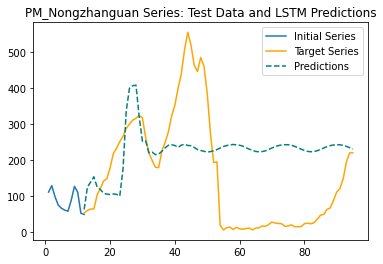

In [31]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

- In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.
- You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. 
- To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures that are beyond the scope of this lesson.
- Take a look at the model summary and compare it with the summary for our simple RNN from example 1. 
    - You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [32]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20160     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


### Further Exploration

The simple models we've worked with are only the tip of the iceberg for deep learning. We've been time-limited for this exercise, and typical deep learning models involve much longer training times than what we're able to do in this notebook. 

Here are several suggestions for how you could explore these ideas further, leveraging the code we've implemented today:

* Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 56), or modeling other series in the dataset.
* When training with more data, try increasing cell_units and running more training epochs.  
* Try using longer input sequences with LSTM, and predicting a wider range of test hours.

# Summary

In this lesson we have covered:

1. How recurrent neural networks can be applied to sequence forecasting problems
2. How simple RNNs and LSTMs can be built and trained using the python library keras
3. The importance of tuning network parameters, and an introductory strategy for doing so


***